In [10]:

from google.cloud import storage
from google.colab import auth
import pandas as pd
from IPython.display import Image
from PIL import Image
import io
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import torch
from torch.utils.data import Dataset
from torchvision import transforms, utils, models
from PIL import Image
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torchvision.models import resnet18, ResNet18_Weights
import torch.optim as optim
from tqdm import tqdm


## Authentication with Google Cloud Platform + Initial Access Testing

In [11]:
# Authenticate with Google Cloud
auth.authenticate_user()

# Instantiates a client
storage_client = storage.Client()

# Access bucket
existing_bucket_name = "thoraticdiseasedataset"
bucket = storage_client.get_bucket(existing_bucket_name)
print(f"Accessed bucket {bucket.name}.")



Accessed bucket thoraticdiseasedataset.


In [12]:

# Load CSV
csv_path = "Stanford_AIMI_CheXpert_Chest_X-rays/chexpertchestxrays-u20210408/train_visualCheXbert.csv"
blob = bucket.blob(csv_path)
df = pd.read_csv(io.StringIO(blob.download_as_text()))
df.head()
#df.dtypes

,Path,Sex,Age,Frontal/Lateral,AP/PA,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,No Finding
0,CheXpert-v1.0/train/patient00001/study1/view1_...,Female,68,Frontal,AP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,CheXpert-v1.0/train/patient00002/study2/view1_...,Female,87,Frontal,AP,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,CheXpert-v1.0/train/patient00002/study1/view1_...,Female,83,Frontal,AP,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
3,CheXpert-v1.0/train/patient00002/study1/view2_...,Female,83,Lateral,NaN,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
4,CheXpert-v1.0/train/patient00003/study1/view1_...,Male,41,Frontal,AP,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


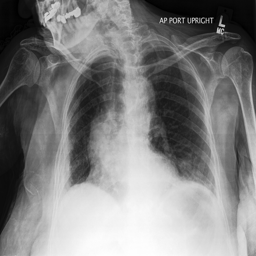

In [13]:
#Test Image retrieval
blob = bucket.get_blob('Stanford_AIMI_CheXpert_Chest_X-rays/chexpertchestxrays-u20210408/CheXpert-v1.0/train/patient13242/study4/view1_frontal.jpg')

# Download the image bytes
image_bytes = blob.download_as_bytes()

image = Image.open(io.BytesIO(image_bytes))

# Resize the image (256x256)
resized_image = image.resize((256, 256))

display(resized_image)

## Data Processing

In [14]:
# Diagnosis Columns
diagnosis_cols = [
    "Enlarged Cardiomediastinum", "Cardiomegaly", "Lung Opacity", "Lung Lesion", "Edema",
    "Consolidation", "Pneumonia", "Atelectasis", "Pneumothorax",
    "Pleural Effusion", "Pleural Other", "Fracture", "Support Devices", "No Finding"
]
# print type
print(df.dtypes)

Path                           object
Sex                            object
Age                             int64
Frontal/Lateral                object
AP/PA                          object
Enlarged Cardiomediastinum    float64
Cardiomegaly                  float64
Lung Opacity                  float64
Lung Lesion                   float64
Edema                         float64
Consolidation                 float64
Pneumonia                     float64
Atelectasis                   float64
Pneumothorax                  float64
Pleural Effusion              float64
Pleural Other                 float64
Fracture                      float64
Support Devices               float64
No Finding                    float64
dtype: object


#### Data Overview and Visualization

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223414 entries, 0 to 223413
Data columns (total 19 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Path                        223414 non-null  object 
 1   Sex                         223414 non-null  object 
 2   Age                         223414 non-null  int64  
 3   Frontal/Lateral             223414 non-null  object 
 4   AP/PA                       191027 non-null  object 
 5   Enlarged Cardiomediastinum  223414 non-null  float64
 6   Cardiomegaly                223414 non-null  float64
 7   Lung Opacity                223414 non-null  float64
 8   Lung Lesion                 223414 non-null  float64
 9   Edema                       223414 non-null  float64
 10  Consolidation               223414 non-null  float64
 11  Pneumonia                   223414 non-null  float64
 12  Atelectasis                 223414 non-null  float64
 13  Pneumothorax  

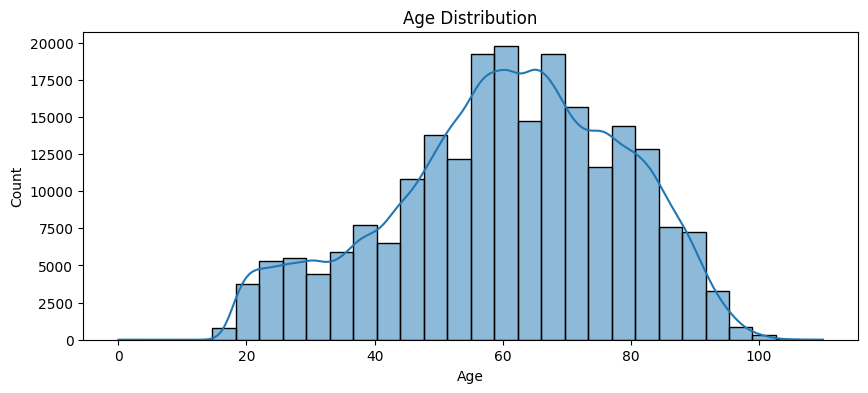

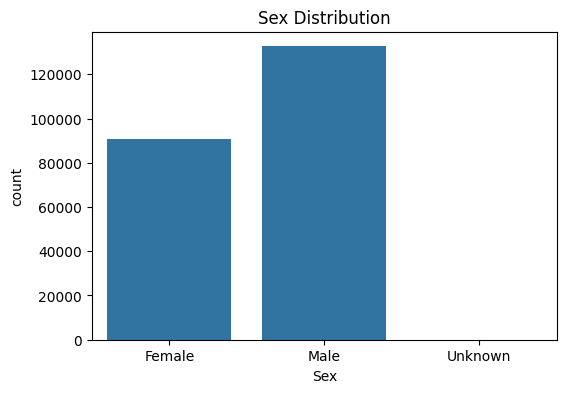

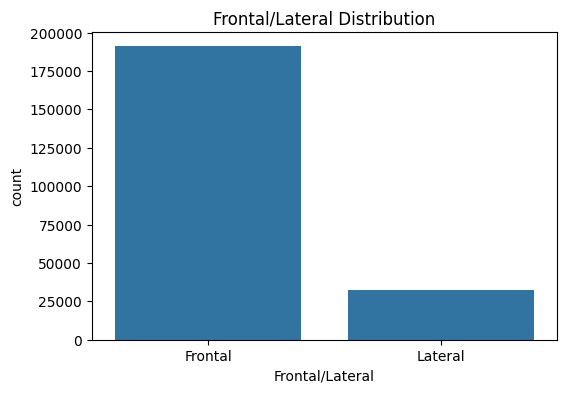

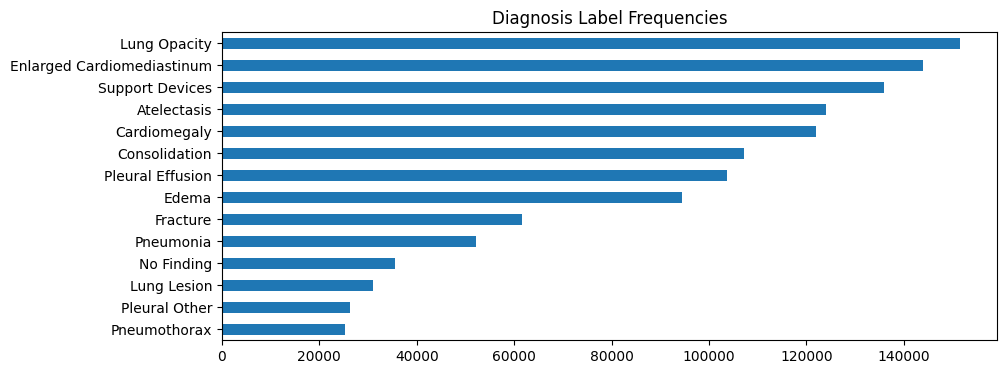

In [15]:
# Intitial Data Visualization
print(df.info())
print(df.describe(include='all'))

# Age Distribution
plt.figure(figsize=(10,4))
sns.histplot(df["Age"].dropna(), bins=30, kde=True)
plt.title("Age Distribution")
plt.show()

#Sex Distribution
plt.figure(figsize=(6,4))
sns.countplot(x="Sex", data=df)
plt.title("Sex Distribution")
plt.show()

#Frontal/Lateral Xray Distribution
plt.figure(figsize=(6,4))
sns.countplot(x="Frontal/Lateral", data=df)
plt.title("Frontal/Lateral Distribution")
plt.show()

# Diagnosis Frequency
plt.figure(figsize=(10,4))
df[diagnosis_cols].sum().sort_values().plot(kind='barh')
plt.title("Diagnosis Label Frequencies")
plt.show()

#### Correlations

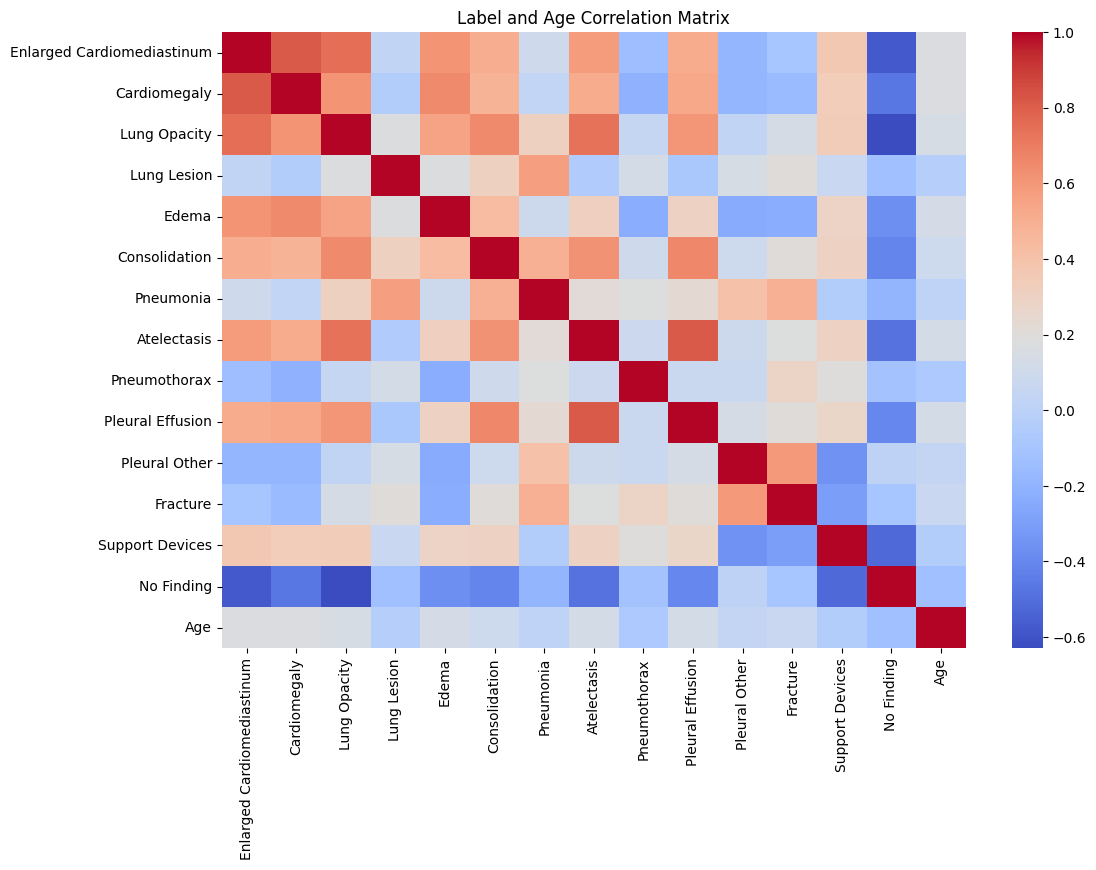

In [16]:
# Correlations
corr_matrix = df[diagnosis_cols + ["Age"]].corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm")
plt.title("Label and Age Correlation Matrix")
plt.show()

#### Attribute Engineering

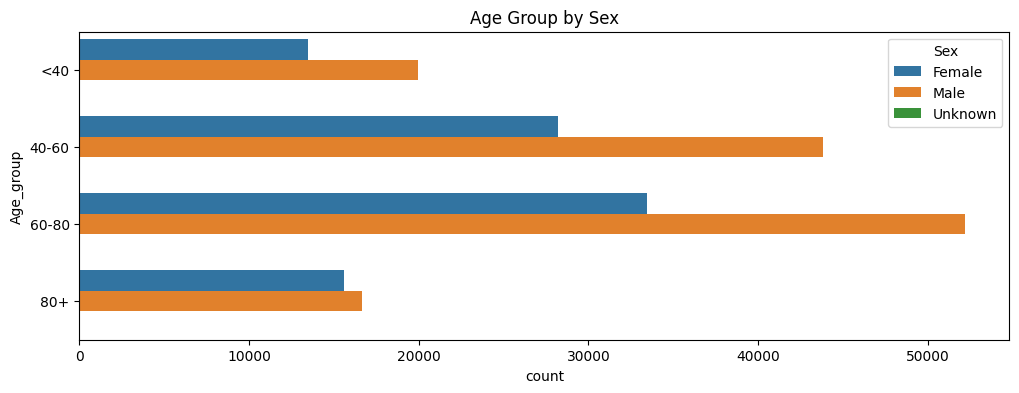

In [ ]:
# Attribute Engineering
df['Age_group'] = pd.cut(df['Age'], bins=[0, 40, 60, 80, 120], labels=['<40','40-60','60-80','80+'])
df['View_Combo'] = df['Frontal/Lateral'].astype(str) + "_" + df['AP/PA'].fillna("Unknown").astype(str)

# Bar Plot
plt.figure(figsize=(12,4))
sns.countplot(y="Age_group", hue="Sex", data=df)
plt.title("Age Group by Sex")
plt.show()

#### Data Cleaning

Missing values per column:
 Path                              0
Sex                               0
Age                               0
Frontal/Lateral                   0
AP/PA                         32387
Enlarged Cardiomediastinum        0
Cardiomegaly                      0
Lung Opacity                      0
Lung Lesion                       0
Edema                             0
Consolidation                     0
Pneumonia                         0
Atelectasis                       0
Pneumothorax                      0
Pleural Effusion                  0
Pleural Other                     0
Fracture                          0
Support Devices                   0
No Finding                        0
Age_group                         3
View_Combo                        0
dtype: int64


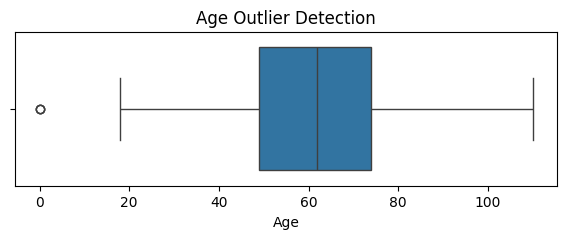

Preprocessing complete. Sample of processed dataframe:
                                                Path   Age  \
0  CheXpert-v1.0/train/patient00001/study1/view1_...  68.0   
1  CheXpert-v1.0/train/patient00002/study2/view1_...  87.0   
2  CheXpert-v1.0/train/patient00002/study1/view1_...  83.0   
3  CheXpert-v1.0/train/patient00002/study1/view2_...  83.0   
4  CheXpert-v1.0/train/patient00003/study1/view1_...  41.0   

   Enlarged Cardiomediastinum  Cardiomegaly  Lung Opacity  Lung Lesion  Edema  \
0                           0             0             0            0      0   
1                           1             1             1            0      1   
2                           1             1             1            1      0   
3                           1             1             1            1      0   
4                           1             1             1            0      1   

   Consolidation  Pneumonia  Atelectasis  ...  AP/PA_PA  AP/PA_RL  \
0              0

In [18]:
# Missing Value Evaluation
print("Missing values per column:\n", df.isnull().sum())
df['Age'] = df['Age'].fillna(df['Age'].median())
df['Sex'] = df['Sex'].fillna('Unknown')
df['Frontal/Lateral'] = df['Frontal/Lateral'].fillna('Unknown')
df['AP/PA'] = df['AP/PA'].fillna('Unknown')
df[diagnosis_cols] = df[diagnosis_cols].fillna(0).astype('int')


# Outlier handling for Age
plt.figure(figsize=(7,2))
sns.boxplot(x=df["Age"])
plt.title("Age Outlier Detection")
plt.show()
df = df[(df["Age"] >= 18) & (df["Age"] <= 100)]  # Cap age to plausible range

# Feature Scaling
scaler = StandardScaler()
df["Age_scaled"] = scaler.fit_transform(df[["Age"]])

# Encoding Categorical Features
df = pd.get_dummies(df, columns=["Sex", "Frontal/Lateral", "AP/PA", "Age_group", "View_Combo"], drop_first=True)


# Convert Booleans into float32
bool_cols = df.select_dtypes(include=['bool']).columns.tolist()
col_to_convert = bool_cols + ['Age']
df[col_to_convert] = df[col_to_convert].astype('float32')

# Dimensionality Reduction
meta_features = df.drop(columns=["Path"] + diagnosis_cols)
pca = PCA(n_components=5)
meta_pca = pca.fit_transform(meta_features)

print("Preprocessing complete. Sample of processed dataframe:")
print(df.head())